# **AN2DL** - Image classification challenge

## Report

###Preview
The folder contains 5 notebooks that has been splitted for the sake of simplicity of explaination: 1_Preprocessing (this notebook), that contains basic operations for loading data e process the images;
2_Base_CNN, that contains all the necessary functions to build a simple CNN; 3_TransferLearning, that has the transfer learning modules addition with respect to the previuos notebook; 4_KerasTuner, that contains an attempt to exploit pre-built keras hyperparameter tuner; 5_K_fold, that contains cross-validation and majority voting implementation.

###Preprocessing
After some basic code to properly load the necessary data, we exploit ImageDataGenerator to primarly rescale the pixels value and then performing data augmention. The latter has been one of the fundamental tool to enhance our network performance.

We have built a pandas DataFrame to load image-class relations and, after shuffling and splitting them into train and validation sets, we have create one generator each. Obviusly only the train one has been provided with augmentation parameter, but this has been learnt the hard way.

###Base CNN
After some repeated code from previous notebook to make all works, here we have started our experiments. We have built two functions, get_feature_extraction and get_classifier, that let us sequentially build a CNN: the first for the convolutional part and the second for the dense part.

We have followed an incremental approach starting from simple networks to better monitor the performance improvements. After some trial and error we managed to boost the test accuracy from an inital 0.573 to a quite satisfactory 0.707 given the rudimentary network (see Table for more info). Since we were not aware how much transfer learning could be expensive in terms of time, we have not spent too much time on basic models with respect to the next ones.

###Transfer learning
A little **disclaimer** on this part: we have decided to concentrate ourselves only on the topics covered at the lectures unitl the launch of the challenge. Indeed our work in this part is mostly built on tuning the best VGG backboned network. We have done some experiments also with ResNet50 and InceptionV3 but most for curiosity.


Here we have started our exploration of transfer learning techniques. We have begun the best setup search by not expoliting fine tuning: leaving the VGG backbone not trainable. After some trials of different top dense layers, we have noticed that performances would not increase a lot. So we have added some fine tuning unfreezing all the network after an initial little train of the top layers only. Obviously the accuracy has increased a lot and we had starte our search for the best network starting from simplest ones. 

Another game-changing parameter that we have started to consider more in this section is the image dimension (already considered in previous phases but less intesively), that we have little at a time pushed to our memory limit. After lots of setup combinations tuning various parameters such as dropout, regularization and more, we have noticed that one dense layer was performing better than most of the other setup as can be seen in the Table of the results.

###Keras tuner
In this section we had tried to ease our work by expoliting an automatic pre-built tuner in the keras library. Unfortunately since the great expensiveness of time of the tuner and the our lack of experience on the usage of the tuner itself, we were not able to achieve great results with it.

###K-fold
In this last section we have implemented some techniques to enhance our model performances: crossvalidation and majority voting. Briefly, the code is structured as a first loop that build k models with the same structure trained on k different train sets (covering all the images available); a second loop that load the trained models and perform a sum over the test predictions of each one to build the submission csv.

These have brought some good improvements in the accuracy of our networks. Improvements that as expected were inversely proportional to the accuracy of the single model.

###Conclusions
The three things that has improved the most our accuarcy are: data augmentation, image dimension and k-fold with majority voting. We have also noticed that the best models were the ones with few (1 or 2 at max) top dense layers with quite high numbers of neurons, and that a low dopout performed way better than regularization. Below we report the Table of the most significant results achievde during the challenge.

## Data import and preprocessing

Configuration and constants:

In [ ]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd

In [ ]:
#Random seed to make experiments reproducible
SEED = 1234
tf.random.set_seed(SEED)  

#Parameters
IMG_H, IMG_W = (400, 400)
BS = 32 #BATCH SIZE
VALIDATION_SPLIT = 0.2
DATA_AUGMENTATION = True

Load Google Drive to get the data and save the results:

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

cwd = os.getcwd()
drive_root_folder = '/content/drive/My Drive/ANN_project/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import the Mask Dataset

Check if the dataset has been already processed, otherwise unzip it.

**N.B.**: we are unzipping in the `/content` folder and not in `drive`.  
If you want to unzip in your drive folder, write `os.chdir(drive_root_folder)`



In [ ]:
#check if the dataset is already available
if not os.path.exists(cwd+'/MaskDataset'):
  !unzip '/content/drive/My Drive/ANN_project/artificial-neural-networks-and-deep-learning-2020.zip'
else:
  print('MaskDataset already loaded')

MaskDataset already loaded


#### Exploration of the dataset

Check the property of the images, such as number of images and sizes.

In [ ]:
import pathlib
path = os.path.join(cwd, 'MaskDataset') 
data_dir = pathlib.Path(path)
training_images = list(data_dir.glob('training/*'))
print(f"number of images: {len(training_images)}")

number of images: 5614


In [ ]:
import PIL

image_sizes = set() #unique sizes
for image in training_images:
  image_sizes.add(PIL.Image.open(str(image)).size)
print(f"number of unique sizes: {len(image_sizes)}")

number of unique sizes: 275


In [ ]:
#explore some of them
size_iter = iter(image_sizes)
for i in range(15):
  print(i, next(size_iter))

0 (612, 423)
1 (612, 508)
2 (427, 612)
3 (612, 326)
4 (345, 612)
5 (612, 552)
6 (612, 434)
7 (612, 463)
8 (434, 612)
9 (612, 397)
10 (612, 566)
11 (612, 408)
12 (612, 469)
13 (463, 612)
14 (612, 354)


### Split the dataset 

Definition of the `ImageDataGenerator` for _data augmentation_:

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

if DATA_AUGMENTATION:
    train_data_gen = ImageDataGenerator(rotation_range=20, 
                                        width_shift_range=0.3, 
                                        height_shift_range=0.3, 
                                        zoom_range=0.4, 
                                        horizontal_flip=True, #
                                        #brightness_range = [0.6, 1.5], 
                                        shear_range=10, 
                                        channel_shift_range=100, 
                                        fill_mode='reflect', 
                                        rescale=1./255)
else:
    train_data_gen = ImageDataGenerator(rescale=1./255)
    
valid_data_gen = ImageDataGenerator(rescale=1./255)

Define the *train* and *validation* dataset through the `pandas` library:

In [ ]:
import json

dataset_dir = os.path.join(cwd, "MaskDataset")
training_dir = os.path.join(dataset_dir, "training")
with open(os.path.join(dataset_dir,"train_gt.json")) as f:
  dic = json.load(f)
  dataframe = pd.DataFrame(dic.items())
  dataframe.rename(columns = {0:'filename', 1:'class'}, inplace = True)
  dataframe = dataframe.sample(frac=1, random_state=SEED)
  
  tot_length = dataframe.shape[0]
  valid = dataframe.iloc[:int(np.ceil(tot_length * VALIDATION_SPLIT)),:] 
  train = dataframe.iloc[int(np.ceil(tot_length * VALIDATION_SPLIT)):,:]
  train["class"] = train["class"].astype('string')
  valid["class"] = valid["class"].astype('string')
  
  train_gen = train_data_gen.flow_from_dataframe(train,
                                               training_dir,
                                               batch_size=BS,
                                               target_size=(IMG_H, IMG_W),
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=SEED)
  
  validation_gen = valid_data_gen.flow_from_dataframe(valid,
                                               training_dir,
                                               batch_size=BS,
                                               target_size=(IMG_H, IMG_W),
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=SEED)

Found 4491 validated image filenames belonging to 3 classes.
Found 1123 validated image filenames belonging to 3 classes.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


Check if the class are balanced:

In [ ]:
valid_iterator = iter(validation_gen)
valid_class_count = np.array([0, 0, 0])
for i in range(len(valid_iterator)):
  valid_img_s , lab_s = next(valid_iterator)
  for lab in lab_s:
    valid_class_count[lab.nonzero()[0]] = valid_class_count[lab.nonzero()[0]] +1
print(f"validation set: {valid_class_count}")
  
train_iterator = iter(train_gen)
train_class_count = np.array([0, 0, 0])
for i in range(len(train_iterator)):
  train_img_s , lab_s = next(train_iterator)
  for lab in lab_s:
    train_class_count[lab.nonzero()[0]] = train_class_count[lab.nonzero()[0]] +1
print(f"train set: {train_class_count}")

validation set: [390 375 358]
train set: [1510 1522 1459]


### Visualization

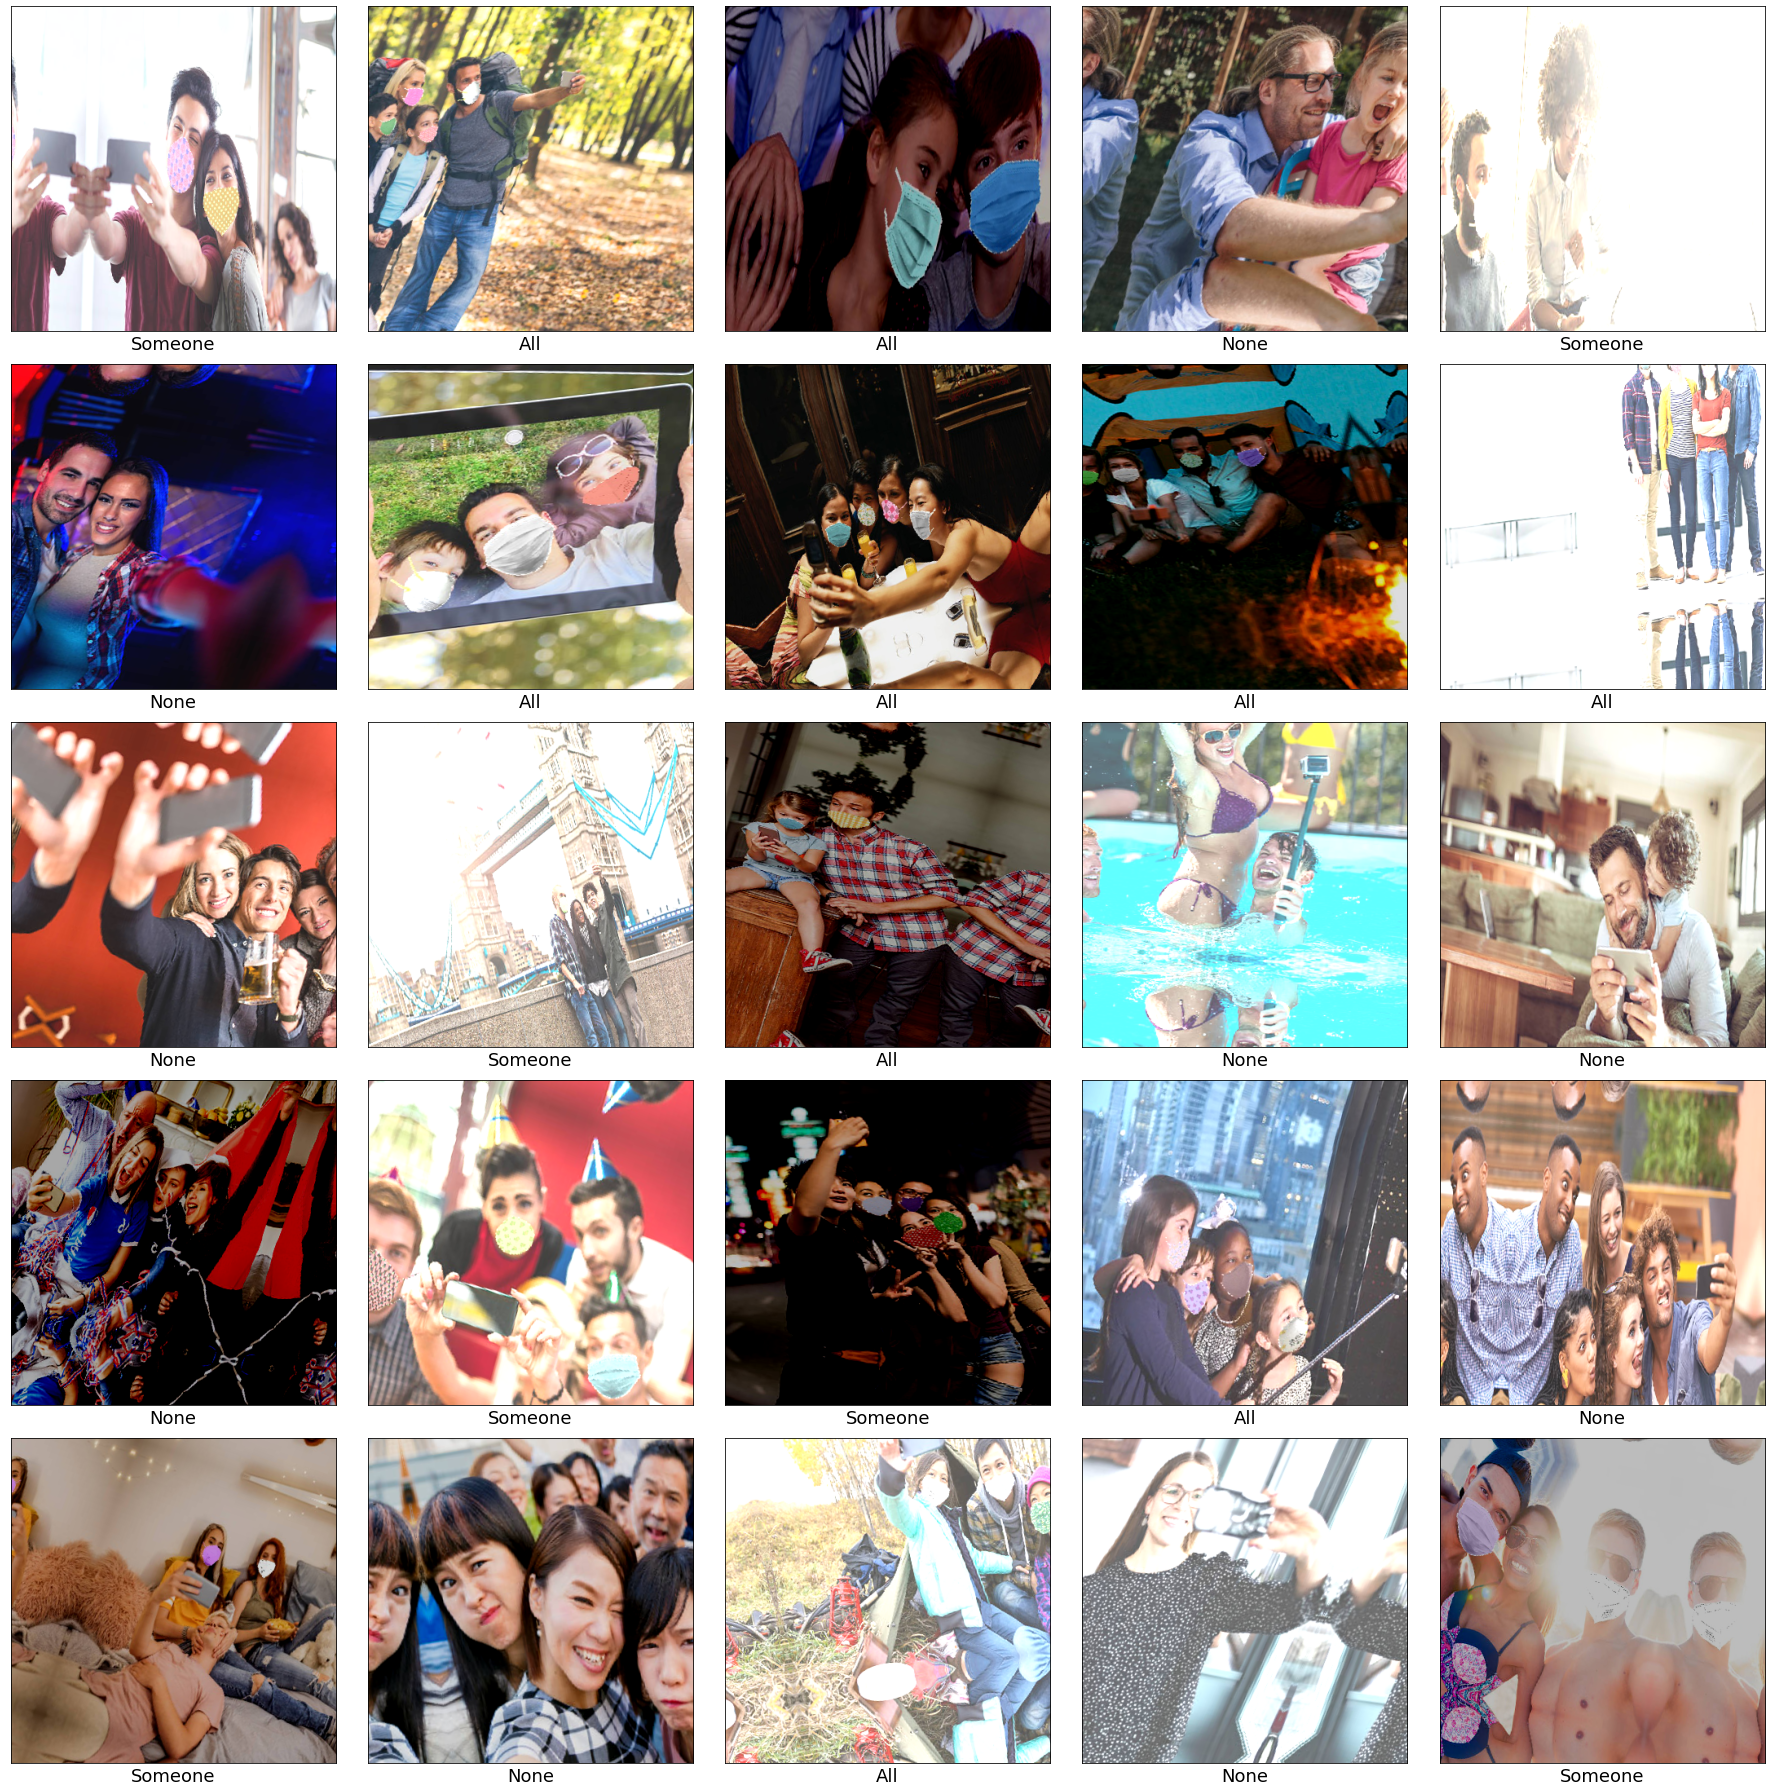

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

x_batch, y_batch = next(train_gen)
classes = np.array(["None", "All", "Someone"])

plt.figure(figsize=(25,25))

for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid=False

  img = x_batch[i] 
  lbl = y_batch[i] 

  plt.imshow(img, cmap=plt.cm.binary)
  plt.xlabel(classes[np.argmax(lbl)], fontsize = 18)
plt.tight_layout()
plt.show()